<center>
<h1><b>Homework 1</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>September 18, 2020</b></h3>
</center>

All questions are worth 10 points, irrespectively of complexity or length. Please submit
all your solutions on Brightspace in PDF format, together with the source code (if any). Make
sure to
- discuss the physics and your results, as appropriate and/or directed
- include graphical output to illustrate the results
- include the source codes of your programs (at least the critical parts thereof)
- describe briefly what your program does, and how it does it (algorithm)
- state the nature of the numerical approximation used, and demonstrate how you know that the particular approximation (with the parameters you used) is adequate for the problem you used it for.


### Imports

In [153]:
%matplotlib inline

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from functools import partial
from sympy import Rational, latex
from numpy import sin, cos
import pymap3d as pm
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import spherical_to_cartesian
from tqdm import tqdm

### Support Functions

In [154]:
R_E = 6371000


def euler_step(f, y, t, dt):
    y = y + f(t, y) * dt
    return y


def rk2_step(f, y, t, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt, y + k1)
    y = y + (k1 + k2) / 2.0
    return y


def rk4_step(f, y, t, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + 0.5 * dt, y + 0.5 * k1)
    k3 = dt * f(t + 0.5 * dt, y + 0.5 * k2)
    k4 = dt * f(t + dt, y + k3)
    y = y + (k1 + 2.0 * (k2 + k3) + k4) / 6.0
    return y


def dsolve(f, t, y0, step = euler_step, terminate = lambda t, x : False):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y0 = np.asarray(y0)

    terminated_at = -1

    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    y[0] = y0  # Set initial condition

    for i in range(np.size(t)-1):
        if terminate(t[i], y[i]):  # Check termination condition
            return t[:i], y[:i, :].T
        else:
            y[i+1] = step(f, y[i], t[i], t[i+1] - t[i])  # Step forward
    return t, y.T


def global_error(y_approx, y_exact):
    return y_approx - y_exact


def local_error(y_approx, y_exact):
    error = np.zeros_like(y_exact)
    for i in np.arange(1, len(error)):
        error[i-1] = y_exact[i] - y_exact[i-1] - (y_approx[i] - y_approx[i-1])
    return error

# Problem 1
Number 1.4 from the Giordano-Nakanishi book (p.16), with $\frac{\tau_A}{\tau_B}= \frac{1}{3}, 1, 3$. Make sure to include a discussion of any relationships among the time scales $\left(\tau_A, \tau_B\right)$ and the time step you chose for the numerical work. Explore and interpret the results for various initial conditions such as $\frac{N_A(0)}{\tau_A} > \frac{N_B(0)}{\tau_B}$, or $\frac{N_A(0)}{\tau_A} < \frac{N_B(0)}{\tau_B}$. 

*Note*, if your analytic result does not “like” $\tau_A = \tau_B$, then you have to set $\tau_B = \tau_A + \epsilon$ in it and then take the $ε ! 0$ limit. (If the limit is giving you trouble, just shift $\tau_B$ by a very small amount). 

*Optional*: How would the differential equations change if B becomes A when it “decays”?

### Function Definitions

In [155]:
def rhs(t, X, ta, tb):
    return np.array([-X[0] / ta, X[0] / ta - X[1] / tb])


def Na(t, ta, tb, Na0, Nb0):
    return Na0 * np.exp(-t / ta)


def Nb(t, ta, tb, Na0, Nb0):
    try:
        return Na0 * (tb / (ta - tb)) * np.exp(-(ta + tb) * t / (ta * tb)) * (np.exp(t / tb) - np.exp(t / ta)) + Nb0 * np.exp(-t / tb)
    except ZeroDivisionError:  # Correction for division by zero when ta == tb
        tb = tb + np.finfo(np.float32).eps  # 64-bit floating point machine epsilon was too small and manifested discrete behavior when analyzing error
        return Nb(t, ta, tb, Na0, Nb0)

### Setup

In [156]:
ta1, ta2, ta3 = 1, 1, 3
tb1, tb2, tb3 = 3, 1, 1
Na0, Nb0 = 1, 0

t = np.linspace(0,20,200)  # dt = 0.1
t1, y1 = dsolve(partial(rhs, ta=ta1, tb=tb1), t, np.asarray([Na0, Nb0]))
t2, y2 = dsolve(partial(rhs, ta=ta2, tb=tb2), t, np.asarray([Na0, Nb0]))
t3, y3 = dsolve(partial(rhs, ta=ta3, tb=tb3), t, np.asarray([Na0, Nb0]))

### Plotting

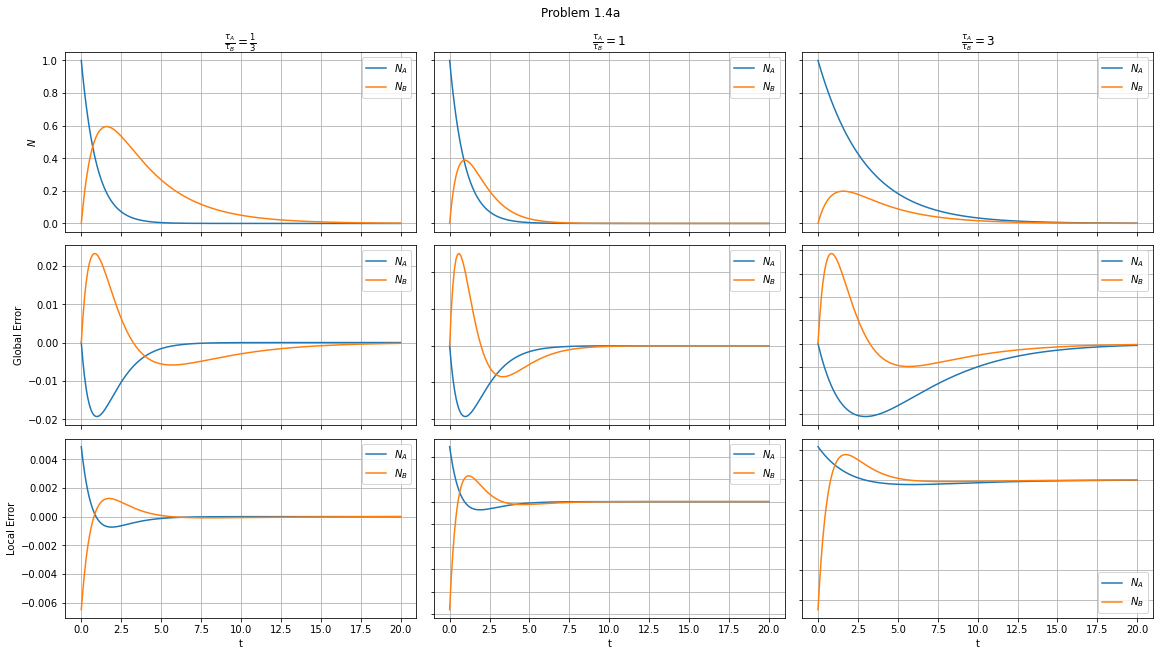

In [157]:
# Plotting
fig, axs = plt.subplots(3, 3, figsize=(16, 9), constrained_layout=True)

axs[0, 0].plot(t, y1[0], label=r"$N_A$")
axs[0, 0].plot(t, y1[1], label=r"$N_B$")
axs[0, 1].plot(t, y2[0], label=r"$N_A$")
axs[0, 1].plot(t, y2[1], label=r"$N_B$")
axs[0, 2].plot(t, y3[0], label=r"$N_A$")
axs[0, 2].plot(t, y3[1], label=r"$N_B$")

axs[1, 0].plot(t1, global_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[1, 0].plot(t1, global_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[1, 1].plot(t2, global_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[1, 1].plot(t2, global_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[1, 2].plot(t3, global_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[1, 2].plot(t3, global_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

axs[2, 0].plot(t1, local_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[2, 0].plot(t1, local_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[2, 1].plot(t2, local_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[2, 1].plot(t2, local_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[2, 2].plot(t3, local_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[2, 2].plot(t3, local_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

for i in range(3):
    for j in range(3):
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel("t")
        axs[0, j].set_ylabel(r"$N$")
        axs[1, j].set_ylabel(r"Global Error")
        axs[2, j].set_ylabel(r"Local Error")

axs[0, 0].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta1, tb1))}$")
axs[0, 1].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta2, tb2))}$")
axs[0, 2].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta3, tb3))}$")
plt.suptitle("Problem 1.4a")
for ax in axs.flat:
    ax.label_outer()

plt.show()

### Setup

In [158]:
ta1, ta2, ta3 = 1, 1, 3
tb1, tb2, tb3 = 3, 1, 1
Na0, Nb0 = 1, 1

t = np.linspace(0,20,200)
t1, y1 = dsolve(partial(rhs, ta=ta1, tb=tb1), t, [Na0, Nb0])
t2, y2 = dsolve(partial(rhs, ta=ta2, tb=tb2), t, [Na0, Nb0])
t3, y3 = dsolve(partial(rhs, ta=ta3, tb=tb3), t, [Na0, Nb0])

### Plotting

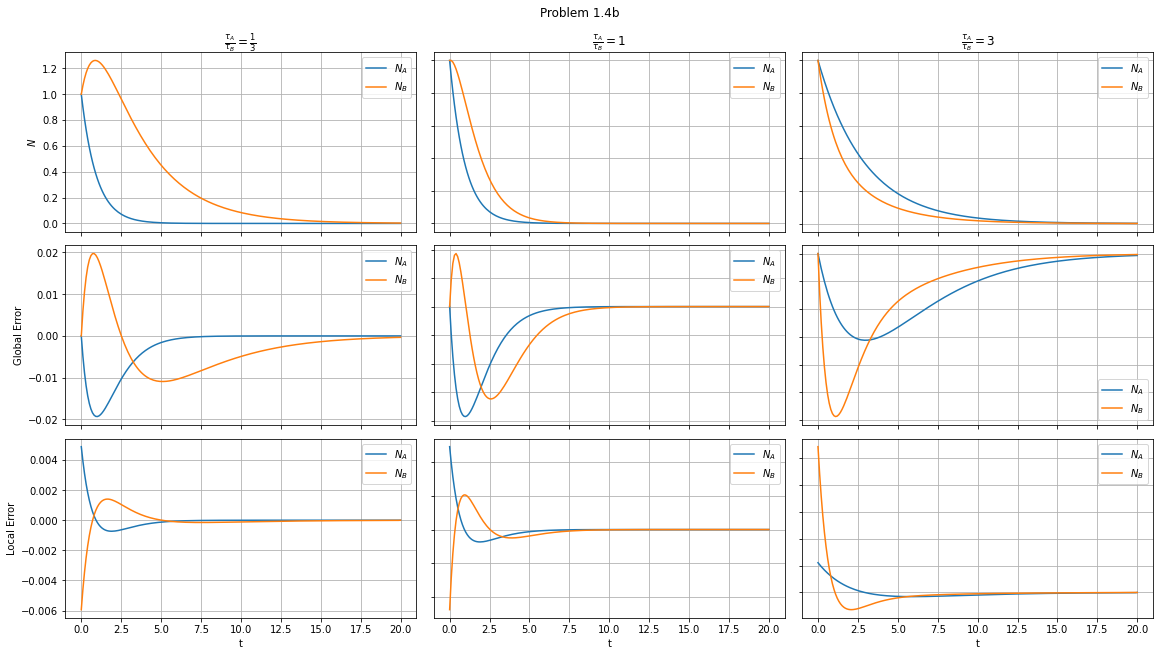

In [159]:
fig, axs = plt.subplots(3, 3, figsize=(16, 9), constrained_layout=True)

axs[0, 0].plot(t, y1[0], label=r"$N_A$")
axs[0, 0].plot(t, y1[1], label=r"$N_B$")
axs[0, 1].plot(t, y2[0], label=r"$N_A$")
axs[0, 1].plot(t, y2[1], label=r"$N_B$")
axs[0, 2].plot(t, y3[0], label=r"$N_A$")
axs[0, 2].plot(t, y3[1], label=r"$N_B$")

axs[1, 0].plot(t1, global_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[1, 0].plot(t1, global_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[1, 1].plot(t2, global_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[1, 1].plot(t2, global_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[1, 2].plot(t3, global_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[1, 2].plot(t3, global_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

axs[2, 0].plot(t1, local_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[2, 0].plot(t1, local_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[2, 1].plot(t2, local_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[2, 1].plot(t2, local_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[2, 2].plot(t3, local_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[2, 2].plot(t3, local_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

for i in range(3):
    for j in range(3):
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel("t")
        axs[0, j].set_ylabel(r"$N$")
        axs[1, j].set_ylabel(r"Global Error")
        axs[2, j].set_ylabel(r"Local Error")

axs[0, 0].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta1, tb1))}$")
axs[0, 1].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta2, tb2))}$")
axs[0, 2].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta3, tb3))}$")
plt.suptitle("Problem 1.4b")
for ax in axs.flat:
    ax.label_outer()

plt.show()

## Optional

### Function Definitions

In [160]:
def rhs(t, X, ta, tb):
    return np.array([X[1] / tb - X[0] / ta, X[0] / ta - X[1] / tb])


def Na(t, ta, tb, Na0, Nb0):
    try:
        return Na0 * (tb * np.exp(-(ta + tb) * t / (ta * tb)) + ta) / (ta + tb) - Nb0 * ta * (np.exp(-(ta + tb) * t / (ta * tb)) - 1) / (ta + tb)
    except ZeroDivisionError:  # Correction for division by zero when ta == tb
        ta = ta + np.finfo(np.float32).eps
        return Nb(t, ta, tb, Na0, Nb0)


def Nb(t, ta, tb, Na0, Nb0):
    try:
        return Nb0 * (ta * np.exp(-(ta + tb) * t / (ta * tb)) + tb) / (ta + tb) - Na0 * tb * (np.exp(-(ta + tb) * t / (ta * tb)) - 1) / (ta + tb)
    except ZeroDivisionError:  # Correction for division by zero when ta == tb
        tb = tb + np.finfo(np.float32).eps
        return Na(t, ta, tb, Na0, Nb0)

### Setup

In [161]:
ta1, ta2, ta3 = 1, 1, 3
tb1, tb2, tb3 = 3, 1, 1
Na0, Nb0 = 1, 0

t = np.linspace(0,20,200)
t1, y1 = dsolve(partial(rhs, ta=ta1, tb=tb1), t, [Na0, Nb0])
t2, y2 = dsolve(partial(rhs, ta=ta2, tb=tb2), t, [Na0, Nb0])
t3, y3 = dsolve(partial(rhs, ta=ta3, tb=tb3), t, [Na0, Nb0])

### Plotting

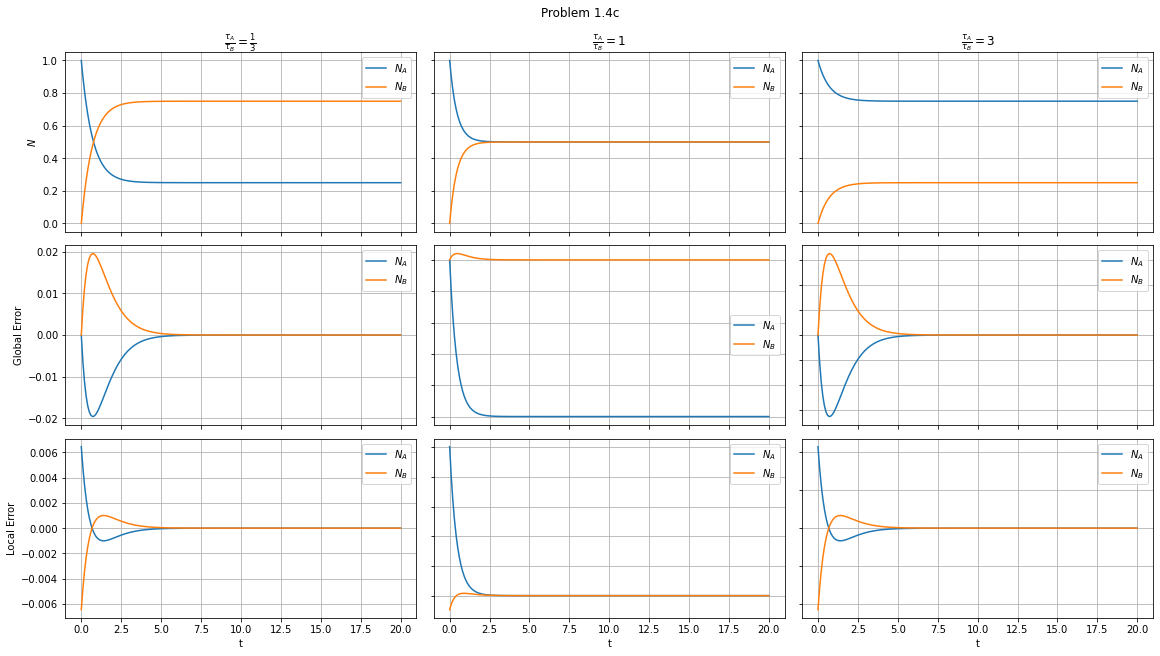

In [162]:
fig, axs = plt.subplots(3, 3, figsize=(16, 9), constrained_layout=True)

axs[0, 0].plot(t, y1[0], label=r"$N_A$")
axs[0, 0].plot(t, y1[1], label=r"$N_B$")
axs[0, 1].plot(t, y2[0], label=r"$N_A$")
axs[0, 1].plot(t, y2[1], label=r"$N_B$")
axs[0, 2].plot(t, y3[0], label=r"$N_A$")
axs[0, 2].plot(t, y3[1], label=r"$N_B$")

axs[1, 0].plot(t1, global_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[1, 0].plot(t1, global_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[1, 1].plot(t2, global_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[1, 1].plot(t2, global_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[1, 2].plot(t3, global_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[1, 2].plot(t3, global_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

axs[2, 0].plot(t1, local_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[2, 0].plot(t1, local_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[2, 1].plot(t2, local_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[2, 1].plot(t2, local_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[2, 2].plot(t3, local_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[2, 2].plot(t3, local_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

for i in range(3):
    for j in range(3):
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel("t")
        axs[0, j].set_ylabel(r"$N$")
        axs[1, j].set_ylabel(r"Global Error")
        axs[2, j].set_ylabel(r"Local Error")

axs[0, 0].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta1, tb1))}$")
axs[0, 1].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta2, tb2))}$")
axs[0, 2].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta3, tb3))}$")
plt.suptitle("Problem 1.4c")
for ax in axs.flat:
    ax.label_outer()

plt.show()

### Setup

In [163]:
ta1, ta2, ta3 = 1, 1, 3
tb1, tb2, tb3 = 3, 1, 1
Na0, Nb0 = 1, 1

t = np.linspace(0,20,200)
t1, y1 = dsolve(partial(rhs, ta=ta1, tb=tb1), t, [Na0, Nb0])
t2, y2 = dsolve(partial(rhs, ta=ta2, tb=tb2), t, [Na0, Nb0])
t3, y3 = dsolve(partial(rhs, ta=ta3, tb=tb3), t, [Na0, Nb0])

### Plotting

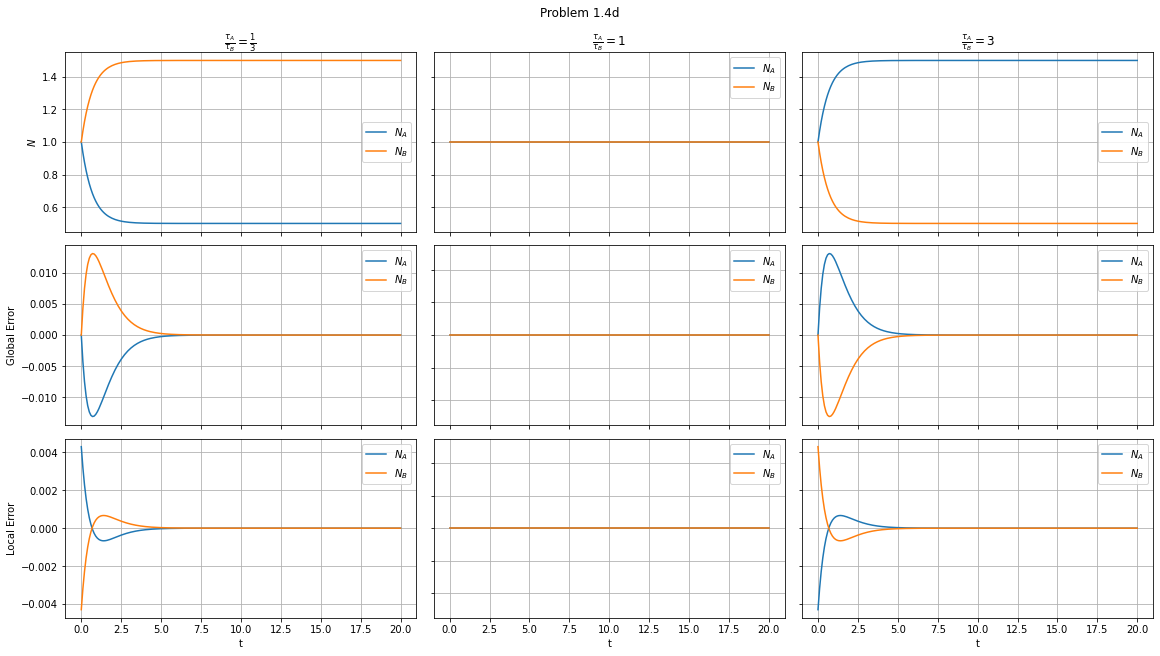

In [164]:
fig, axs = plt.subplots(3, 3, figsize=(16, 9), constrained_layout=True)

axs[0, 0].plot(t, y1[0], label=r"$N_A$")
axs[0, 0].plot(t, y1[1], label=r"$N_B$")
axs[0, 1].plot(t, y2[0], label=r"$N_A$")
axs[0, 1].plot(t, y2[1], label=r"$N_B$")
axs[0, 2].plot(t, y3[0], label=r"$N_A$")
axs[0, 2].plot(t, y3[1], label=r"$N_B$")

axs[1, 0].plot(t1, global_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[1, 0].plot(t1, global_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[1, 1].plot(t2, global_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[1, 1].plot(t2, global_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[1, 2].plot(t3, global_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[1, 2].plot(t3, global_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

axs[2, 0].plot(t1, local_error(y1[0], Na(t1, ta1, tb1, Na0, Nb0)), label=r"$N_A$")
axs[2, 0].plot(t1, local_error(y1[1], Nb(t1, ta1, tb1, Na0, Nb0)), label=r"$N_B$")
axs[2, 1].plot(t2, local_error(y2[0], Na(t2, ta2, tb2, Na0, Na0)), label=r"$N_A$")
axs[2, 1].plot(t2, local_error(y2[1], Nb(t2, ta2, tb2, Na0, Nb0)), label=r"$N_B$")
axs[2, 2].plot(t3, local_error(y3[0], Na(t3, ta3, tb3, Na0, Nb0)), label=r"$N_A$")
axs[2, 2].plot(t3, local_error(y3[1], Nb(t3, ta3, tb3, Na0, Nb0)), label=r"$N_B$")

for i in range(3):
    for j in range(3):
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel("t")
        axs[0, j].set_ylabel(r"$N$")
        axs[1, j].set_ylabel(r"Global Error")
        axs[2, j].set_ylabel(r"Local Error")

axs[0, 0].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta1, tb1))}$")
axs[0, 1].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta2, tb2))}$")
axs[0, 2].set_title(rf"$\frac{{\tau_A}}{{\tau_B}} = {latex(Rational(ta3, tb3))}$")
plt.suptitle("Problem 1.4d")
for ax in axs.flat:
    ax.label_outer()

plt.show()

# Problem 2
2.2 (p.24)
Investigate the effect of varying both the rider's power and frontal area on the ultimate velocity. In particular, for a rider in the middle of the pack, the effective frontal area is about 30 percent less than for a rider at the front. How much less energy does a rider in the pack expend than does one at the front, assuming they both move at a velocity of 13 m/s?

### Constants

In [165]:
g = 9.81  # Gravitational Acceleration [m/s^2]
P = 400  # Power [W]
m = 70  # Mass [kg]
v0 = 4  # Initial velocity [m/s]
C = 0.5  # Drag coefficient
A = 0.33  # Cross-sectional area [m^2]
rho = 1.225  # Air density [kg/m^3]

### Function Definitions

In [166]:
def rhs(t, X, A):
    return np.array([P / (m * X[0]) - 0.5 * C * rho * A * X[0] ** 2 / m, ])


def rhs2(t, X, A):
    return np.array([X[1], P / (m * X[1]) - 0.5 * C * rho * A * X[1] ** 2 / m])


def W_d(X, A):
    return X[0] * 0.5 * C * rho * A * X[1] ** 2


def v(t):
    return np.sqrt(2 * P * t / m + v0 ** 2)

### Setup

In [167]:
t = np.linspace(0,200,20000)
ic = np.array([v0, ])
ic2 = np.array([0, v0])

t1, y1 = dsolve(partial(rhs, A=A), t, ic)
t2, y2 = dsolve(partial(rhs, A=0.3*A), t, ic)
t3, y3 = dsolve(partial(rhs2, A=A), t, ic2)
t4, y4 = dsolve(partial(rhs2, A=0.3*A), t, ic2)

### Plotting

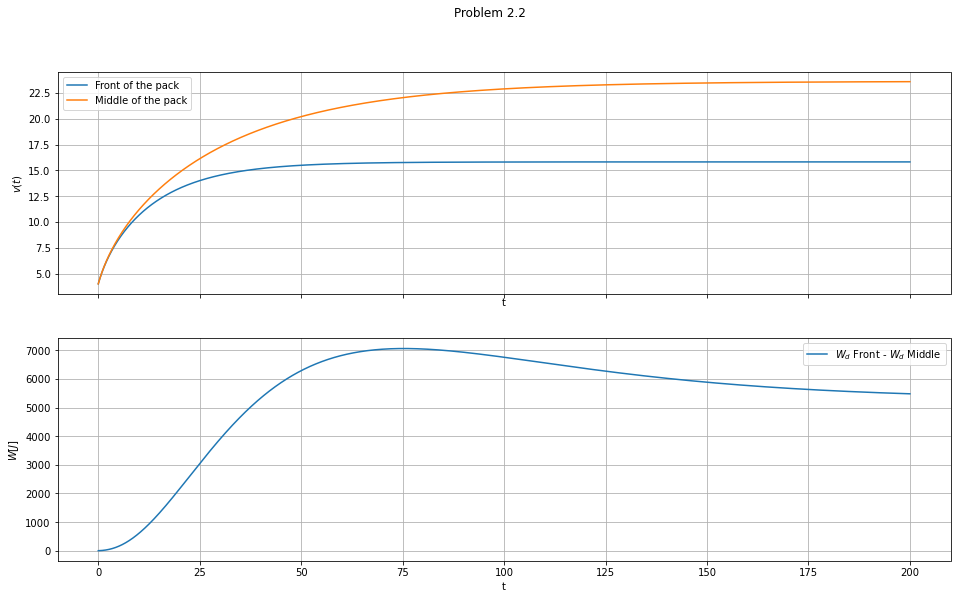

In [168]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

ax[0].plot(t, y1[0], label="Front of the pack")
ax[0].plot(t, y2[0], label="Middle of the pack")
ax[1].plot(t, W_d(y3, A)-W_d(y4, 0.3*A), label=r"$W_d$ Front - $W_d$ Middle")

ax[0].legend()
ax[0].grid()
ax[0].set_xlabel("t")
ax[0].set_ylabel(r"$v(t)$")

ax[1].legend()
ax[1].grid()
ax[1].set_xlabel("t")
ax[1].set_ylabel(r"$W [J]$")

plt.suptitle("Problem 2.2")
plt.show()

# Problem 3
2.7 (p.31)

## Constants

In [169]:
g = 9.81  # Gravitational acceleration [m/s^2]
air_density = 1.225  # Air density [kg/m^3]
m = 47.5  # Mass [kg] of a 10 cm lead sphere
B2_ref = 4.0e-5 * m  # Air resistance coefficient
a = 6.5e-3  # Adiabatic model parameter [K/m]
alpha = 2.5  # Adiabatic model parameter
y_0 = 1.0e4  # k_B*T/mg [m]
T_0 = 300  # Adiabatic model sea level temperature [K]
T_hot = 310.9278  # "Hot summer day" temperature ~ 100 [F]
T_cold = 266.4833  # "Cold winter day" temperature ~ 20 [F]

## Function Definitions

In [170]:
def rhs_adiabatic(t, X, T):
    v = np.sqrt(X[2] ** 2 + X[3] ** 2)
    return np.array([
        X[2], 
        X[3], 
        -B2_ref * (T_0 / T) ** alpha * (1 - a * X[1] / T_0) ** alpha * v * X[2] / m,
        -g - B2_ref * (T_0 / T) ** alpha * (1 - a * X[1] / T_0) ** alpha * v * X[3] / m])


def rhs_isothermal(t, X, T):
    v = np.sqrt(X[2] ** 2 + X[3] ** 2)
    return np.array([
        X[2], 
        X[3], 
        -B2_ref * (T_0 / T) ** alpha * np.exp(-X[1]/y_0) * v * X[2] / m,
        -g - B2_ref * (T_0 / T) ** alpha * np.exp(-X[1]/y_0) * v * X[3] / m])


def rhs(t, X):
    return np.array([
        X[2], 
        X[3], 
        0, 
        -g])


def terminate(t, X):
    return X[1] < 0


def f_ic(theta):
    return np.asarray([x0, y0, v0 * np.cos(np.pi * theta / 180), v0 * np.sin(np.pi * theta / 180)])

## Setup

In [171]:
x0 = y0 = 0
v0 = 700
theta1, theta2, theta3 = np.pi / 6, np.pi / 4, np.pi / 3
t = np.linspace(0, 200, 20000)

initial_state_1 = np.asarray([x0, y0, v0 * np.cos(theta1), v0 * np.sin(theta1)])
initial_state_2 = np.asarray([x0, y0, v0 * np.cos(theta2), v0 * np.sin(theta2)])
initial_state_3 = np.asarray([x0, y0, v0 * np.cos(theta3), v0 * np.sin(theta3)])

## Part A

In [172]:
t00, y00 = dsolve(partial(rhs_adiabatic,  T=T_0), t, initial_state_1, terminate=terminate)
t01, y01 = dsolve(partial(rhs_adiabatic,  T=T_0), t, initial_state_2, terminate=terminate)
t02, y02 = dsolve(partial(rhs_adiabatic,  T=T_0), t, initial_state_3, terminate=terminate)
t10, y10 = dsolve(partial(rhs_isothermal, T=T_0), t, initial_state_1, terminate=terminate)
t11, y11 = dsolve(partial(rhs_isothermal, T=T_0), t, initial_state_2, terminate=terminate)
t12, y12 = dsolve(partial(rhs_isothermal, T=T_0), t, initial_state_3, terminate=terminate)

### Plotting

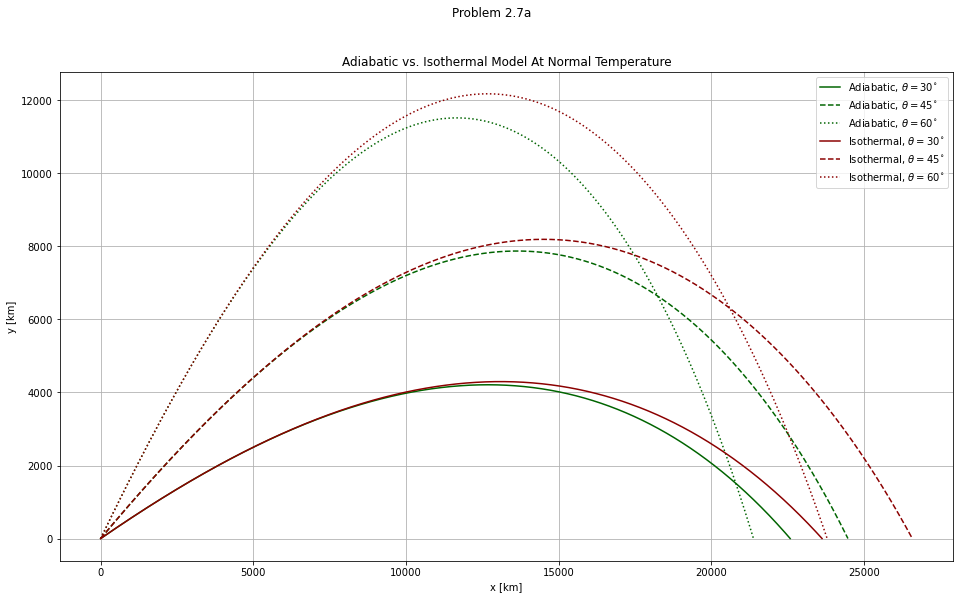

In [173]:
_, ax = plt.subplots(1, 1, figsize=(16,9))
ax.plot(y00[0], y00[1], ls='-', color='darkgreen', label=r"Adiabatic, $\theta = 30^{\circ}$")
ax.plot(y01[0], y01[1], ls='dashed', color='darkgreen', label=r"Adiabatic, $\theta = 45^{\circ}$")
ax.plot(y02[0], y02[1], ls='dotted', color='darkgreen', label=r"Adiabatic, $\theta = 60^{\circ}$")
ax.plot(y10[0], y10[1], ls='-', color='darkred', label=r"Isothermal, $\theta = 30^{\circ}$")
ax.plot(y11[0], y11[1], ls='dashed', color='darkred', label=r"Isothermal, $\theta = 45^{\circ}$")
ax.plot(y12[0], y12[1], ls='dotted', color='darkred', label=r"Isothermal, $\theta = 60^{\circ}$")


ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("Adiabatic vs. Isothermal Model At Normal Temperature")
plt.suptitle("Problem 2.7a")
ax.legend()
ax.grid()
plt.show()

## Part B

In [174]:
t20, y20 = dsolve(partial(rhs_adiabatic, T=T_cold), t, initial_state_1, terminate=terminate)
t21, y21 = dsolve(partial(rhs_adiabatic, T=T_cold), t, initial_state_2, terminate=terminate)
t22, y22 = dsolve(partial(rhs_adiabatic, T=T_cold), t, initial_state_3, terminate=terminate)
t30, y30 = dsolve(partial(rhs_adiabatic, T=T_hot), t, initial_state_1, terminate=terminate)
t31, y31 = dsolve(partial(rhs_adiabatic, T=T_hot), t, initial_state_2, terminate=terminate)
t32, y32 = dsolve(partial(rhs_adiabatic, T=T_hot), t, initial_state_3, terminate=terminate)

### Plotting

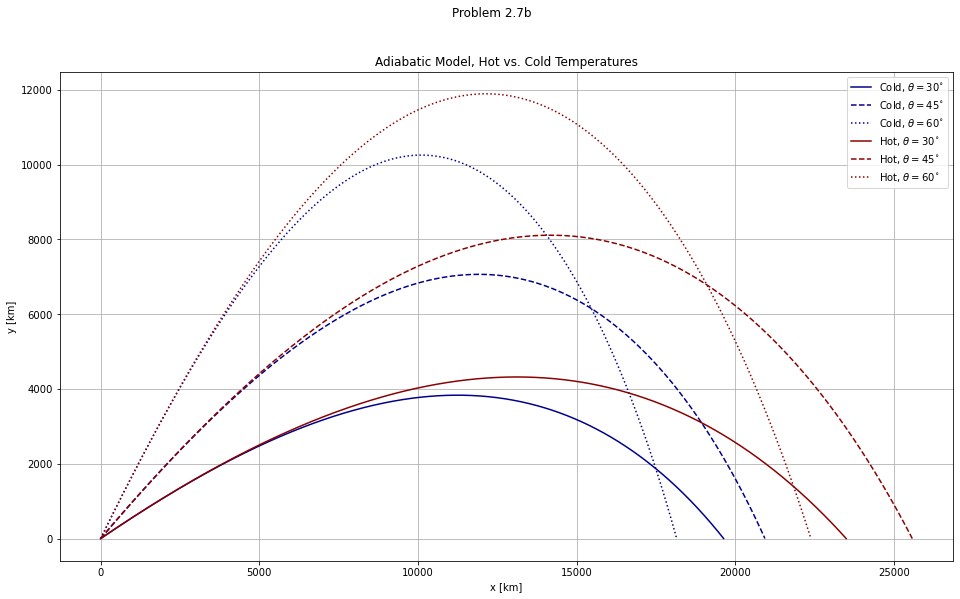

In [175]:
_, ax = plt.subplots(1, 1, figsize=(16,9))
ax.plot(*y20[:2], ls='-', color='darkblue', label=r"Cold, $\theta = 30^{\circ}$")
ax.plot(*y21[:2], ls='dashed', color='darkblue', label=r"Cold, $\theta = 45^{\circ}$")
ax.plot(*y22[:2], ls='dotted', color='darkblue', label=r"Cold, $\theta = 60^{\circ}$")
ax.plot(*y30[:2], ls='-', color='darkred', label=r"Hot, $\theta = 30^{\circ}$")
ax.plot(*y31[:2], ls='dashed', color='darkred', label=r"Hot, $\theta = 45^{\circ}$")
ax.plot(*y32[:2], ls='dotted', color='darkred', label=r"Hot, $\theta = 60^{\circ}$")

ax.legend()
ax.grid()
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("Adiabatic Model, Hot vs. Cold Temperatures")
plt.suptitle("Problem 2.7b")
plt.show()

# Problem 4
In all calculations of cannon shots so far, we neglected the fact that the projectiles are
launched from and measured in the rotating reference frame of Earth. Taking rotation into
account would add a term $−2\vec{\omega}\times\vec{v}$ to the apparent acceleration in Earth’s frame of reference (due to the Coriolis force), making even the spinless cannon problem 3-dimensional. Estimate the effect of the Coriolis force on the trajectory of a typical cannonball launched toward southeast from Lafayette (latitude 40◦ 25’ N) with $v_0 = 700$ m/s at $\theta = 45$ degrees with respect to the horizontal.


Purdue: 40.4237° N, -86.9212° E

## Constants

In [176]:
g = 9.81  # Gravitational acceleration [m/s^2]
air_density = 1.225  # Air density [kg/m^3]
m = 47.5  # Mass [kg] of a 10 cm lead sphere
B2_ref = 4.0e-5 * m  # Air resistance coefficient
a = 6.5e-3  # Adiabatic model parameter [K/m]
alpha = 2.5  # Adiabatic model parameter
y_0 = 1.0e4  # k_B*T/mg [m]
T_0 = 300  # Adiabatic model sea level temperature [K]
T_hot = 310.9278  # "Hot summer day" temperature ~ 100 [F]
T_cold = 266.4833  # "Cold winter day" temperature ~ 20 [F]
m1 = 1.0
m2 = 5.9722e24  # Earth Mass
G = 6.673e-11  # Gravitational Constant
Omega = np.array([0,0,7.2921150e-5])# Earth Angular Velocity [deg]/[s]

R_E = 6371000

phi0 = 40.431350
lambda0 = -86.916710
h0 = 187

E = 45*(np.pi/180)
A = 315*(np.pi/180)
v0 = 700

## Function Definitions

In [177]:
def rhs(t, X, T, omega = Omega):  # Adiabatic with Magnus Effect
    x, dx = np.hsplit(X, 2)
    r = np.linalg.norm(x)
    dr = np.linalg.norm(dx)
    
    return np.concatenate((dx,
                           -m1 * m2 * G * x / r ** 3 \
                           -2 * np.cross(omega,dx) \
                           - B2_ref * (T_0 / T) ** alpha * (1 - a * (r - R_E) / T_0) ** alpha * dr * dx / m))


def terminate(t, X):
    return pm.ecef2enu(*X[:3], phi0, lambda0, h0)[2] < 0.0

## Setup

In [178]:
t = np.linspace(0, 200, 20000)
pos0 = np.asarray(pm.geodetic2ecef(phi0,lambda0,h0, deg=True))
local = pm.utils.sph2cart(A,E,v0)
dpos0 = np.asarray(pm.enu2ecef(*local, phi0, lambda0, h0, deg=True)) - pos0
state0 = np.concatenate((pos0, dpos0))

## Part A

In [179]:
t_magnus, soln_magnus = dsolve(partial(rhs, T=T_0), t, state0, terminate=terminate)
t, soln = dsolve(partial(rhs, T=T_0, omega=np.zeros_like(Omega)), t, state0, terminate=terminate)

pos_magnus, dpos_magnus = np.vsplit(soln_magnus, 2)
pos, dpos = np.vsplit(soln, 2)

pos_enu_magnus = np.zeros_like(pos_magnus).T
pos_enu = np.zeros_like(pos).T

for i, coord in enumerate(tqdm(pos.T)):
     pos_enu[i] = pm.ecef2enu(*coord, phi0, lambda0, h0)

for i, coord_magnus in enumerate(tqdm(pos_magnus.T)):
     pos_enu_magnus[i] = pm.ecef2enu(*coord_magnus, phi0, lambda0, h0)

pos_enu = pos_enu.T
pos_enu_magnus = pos_enu_magnus.T


print(f'\n\nDisplacement (East, North, Up): {(pos_enu_magnus[:,-1]-pos_enu_magnus[:,0])/1000} [km]')

100%|██████████| 7866/7866 [00:00<00:00, 12061.32it/s]

Displacement (East, North, Up): [ 1.64418257e+01 -1.64983449e+01  1.03325939e-03] [km]



### Plotting

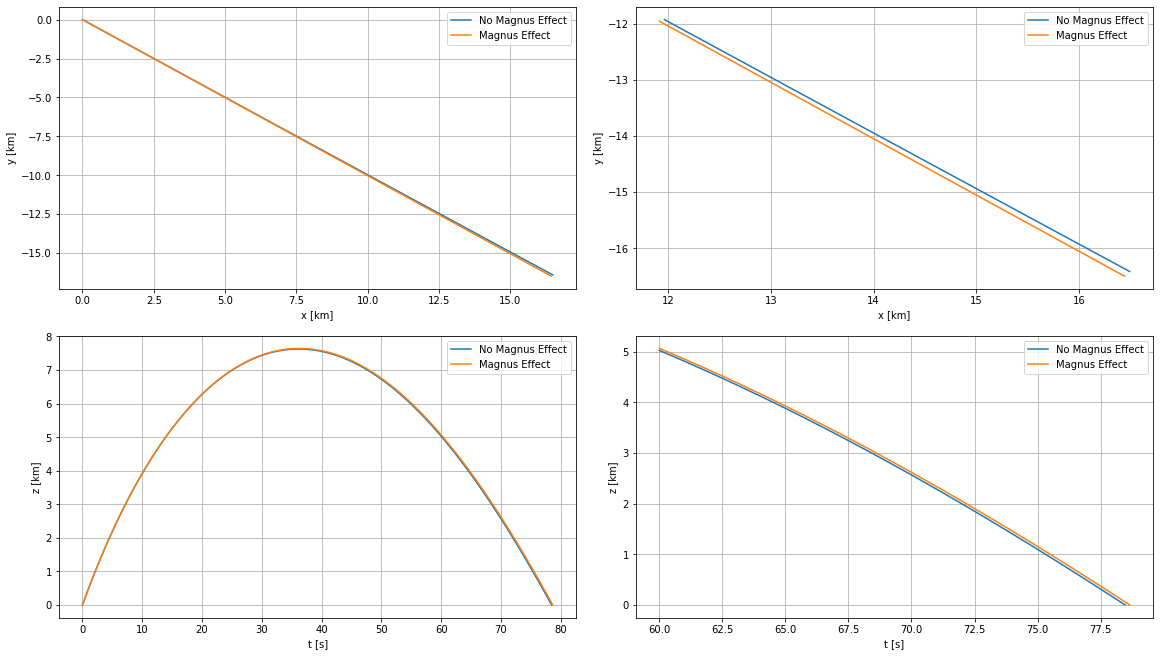

In [180]:
fig, ax = plt.subplots(2, 2, figsize=(16,9), constrained_layout=True)

ax[0, 0].plot(pos_enu[0]/1000, pos_enu[1]/1000, label="No Magnus Effect")
ax[0, 0].plot(pos_enu_magnus[0]/1000, pos_enu_magnus[1]/1000, label="Magnus Effect")
ax[0, 0].set_xlabel('x [km]')
ax[0, 0].set_ylabel('y [km]')
ax[0, 0].legend()
ax[0, 0].grid()
ax[0, 1].plot(pos_enu[0,5000:]/1000, pos_enu[1,5000:]/1000, label="No Magnus Effect")
ax[0, 1].plot(pos_enu_magnus[0,5000:]/1000, pos_enu_magnus[1,5000:]/1000, label="Magnus Effect")
ax[0, 1].set_xlabel('x [km]')
ax[0, 1].set_ylabel('y [km]')
ax[0, 1].legend()
ax[0, 1].grid()

ax[1, 0].plot(t, pos_enu[2]/1000, label='No Magnus Effect')
ax[1, 0].plot(t_magnus, pos_enu_magnus[2]/1000, label='Magnus Effect')
ax[1, 0].set_xlabel('t [s]')
ax[1, 0].set_ylabel('z [km]')
ax[1, 0].legend()
ax[1, 0].grid()
ax[1, 1].plot(t[6000:], pos_enu[2,6000:]/1000, label='No Magnus Effect')
ax[1, 1].plot(t_magnus[6000:], pos_enu_magnus[2,6000:]/1000, label='Magnus Effect')
ax[1, 1].set_xlabel('t [s]')
ax[1, 1].set_ylabel('z [km]')
ax[1, 1].legend()
ax[1, 1].grid()


plt.show()

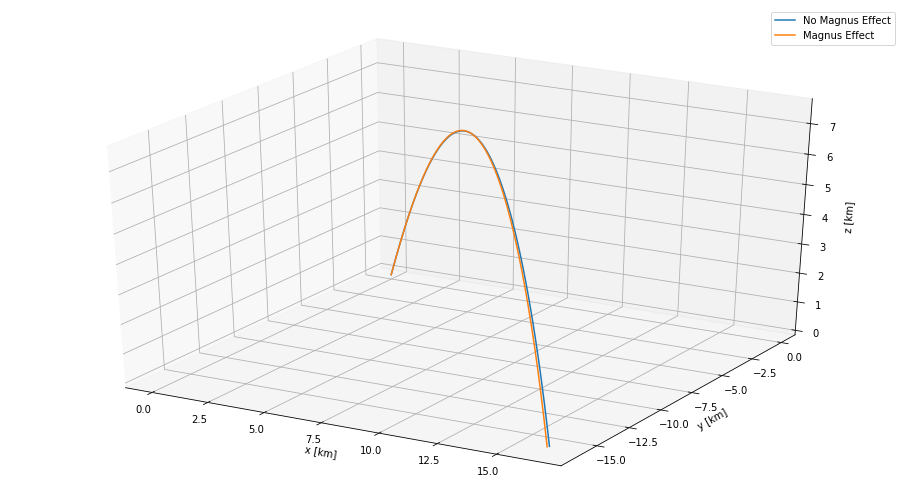

In [181]:
fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')
ax.plot(pos_enu[0]/1000, pos_enu[1]/1000, pos_enu[2]/1000, label='No Magnus Effect')
ax.plot(pos_enu_magnus[0]/1000, pos_enu_magnus[1]/1000, pos_enu_magnus[2]/1000, label='Magnus Effect')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.legend()
plt.show()

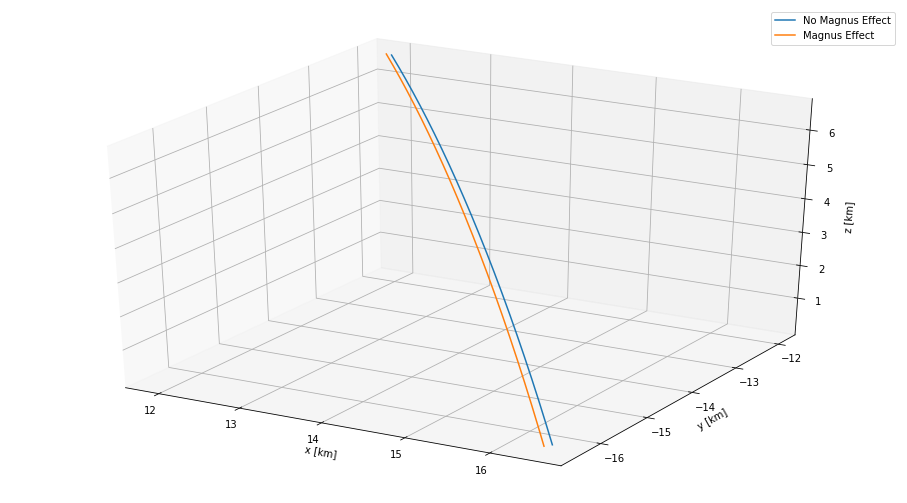

In [182]:
fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')
ax.plot(pos_enu[0,5000:]/1000, pos_enu[1,5000:]/1000, pos_enu[2,5000:]/1000, label='No Magnus Effect')
ax.plot(pos_enu_magnus[0,5000:]/1000, pos_enu_magnus[1,5000:]/1000, pos_enu_magnus[2,5000:]/1000, label='Magnus Effect')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.legend()
plt.show()

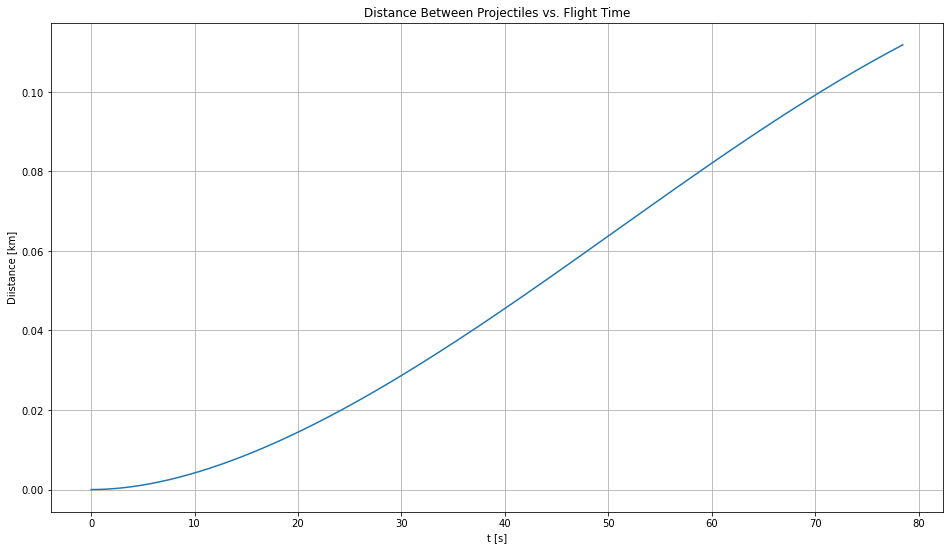

In [183]:
enu_len = np.shape(pos_enu)[1]
enu_magnus_len = np.shape(pos_enu_magnus)[1]
if enu_len > enu_magnus_len:
   pos_enu = pos_enu[:, :enu_magnus_len]
   t = t_magnus
else:
    pos_enu_magnus = pos_enu_magnus[:, :enu_len]

fig = plt.figure(figsize=(16,9))
plt.plot(t, np.linalg.norm((pos_enu_magnus- pos_enu)/1000, axis=0))
plt.xlabel('t [s]')
plt.title('Distance Between Projectiles vs. Flight Time')
plt.ylabel('Diistance [km]')
plt.grid()
plt.show()

# Problem 5
(Order of magnitude checks.) On p.28 of the Giordano-Nakanishi book, the air drag coefficient for a large cannon shell is said to be $B_2/m \approx 4\times10^{−5} \text{m}^{−1}$. On p.38, the magnitude of the Magnus term in baseball is stated to be $S_0/m \approx 4.1 \times 10^{−4}$. Furthermore, p.45 gives an estimate $S_0\omega/m \approx 0.25 \text{s}^{−1}$ for the golf ball, and the next page (p.46, Problem 2.24) says that for a ping-pong ball $S_0/m \approx 0.040$. Argue about the orders of magnitude of these values, and justify them if you can. If needed, refer to the official specifications for the various balls (see, e.g., the document BallSpecs.pdf posted in the Supplemental Materials section of the course home page). If you think that any of the above numbers in the text are unreasonable, then
state why that is so.

In [184]:
baseball_mass = 0.5 * (141.75e-3 + 148.83e-3)
baseball_radius = 0.5 * (72.64e-3 + 74.68e-3) * 0.5  # Average radius of a baseball in [m]
baseball_csa    = np.pi*(baseball_radius)**2
baseball_drag =  4.1e-4

cannonball_mass = 0.5*(4+6) * 0.453592
cannonball_radius = 0.5 * (2.99+3.43) * 0.0254  # Average radius of a cannon ball in [m]
cannonball_csa  = np.pi*(cannonball_radius)**2
cannonball_drag = 4.0e-5

golf_ball_mass = 45.93e-3
golf_ball_radius = 42.67e-3 * 0.5
golf_ball_csa     = np.pi*(golf_ball_radius)**2
golf_ball_drag = 0.25

pingpong_ball_mass = 2.7e-3
pingpong_ball_radius = 40.0e-3 * 0.5
pingpong_ball_csa = np.pi*(pingpong_ball_radius)**2
pingpong_ball_drag = 0.04

mass = (baseball_mass, cannonball_mass, golf_ball_mass, pingpong_ball_mass)
radius = (baseball_radius, cannonball_radius, golf_ball_radius, pingpong_ball_radius)
csa = (baseball_csa, cannonball_csa, golf_ball_csa, pingpong_ball_csa)
drag = (baseball_drag, cannonball_drag, golf_ball_drag, pingpong_ball_drag)

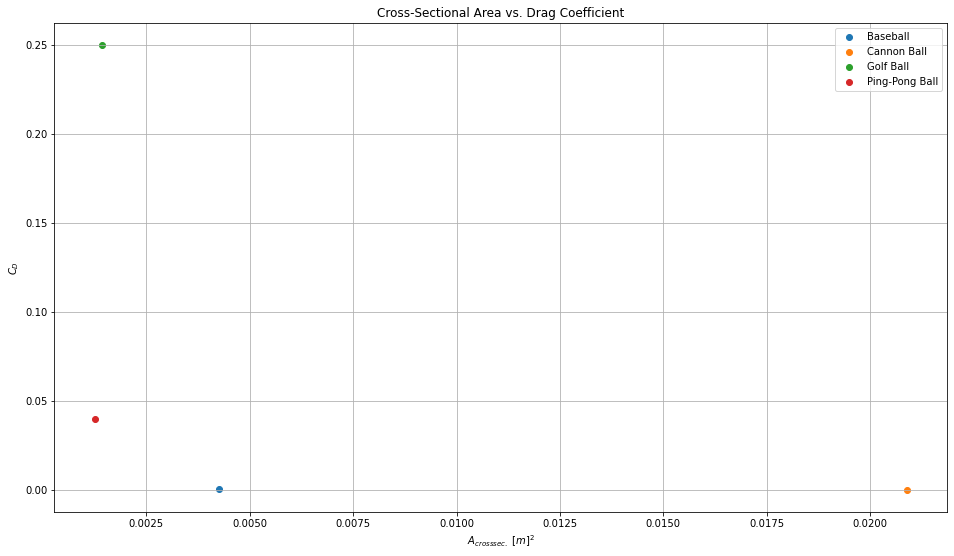

In [185]:
fig, ax2 = plt.subplots(1, 1, figsize=(16,9))
ax2.scatter(     baseball_csa,     baseball_drag,label='Baseball')
ax2.scatter(   cannonball_csa,   cannonball_drag,  label='Cannon Ball')
ax2.scatter(    golf_ball_csa,    golf_ball_drag,    label='Golf Ball')
ax2.scatter(pingpong_ball_csa,pingpong_ball_drag,label='Ping-Pong Ball')
ax2.set_title('Cross-Sectional Area vs. Drag Coefficient')
ax2.set_xlabel(r'$A_{crosssec.}$ $[m]^2$')
ax2.set_ylabel(r'$C_D$')
ax2.grid()
ax2.legend()

plt.show()

There appears to be a relationship between the cross-sectional area of the objects and their drag coefficients, barring the golf ball, which has intentionally modified its structure to manipulate its flight properties. Therefore, it makes sense for the orders of magnitude to be how they are, the dynamics of these objects are very complex and sensitive to minute differences in materials, surface topography, etc.